# Supplement B
# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
Williams et al. (2014) suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by Testud et al. (2001).

Williams et al. (2014) analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m$ or $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in Williams et al. (2014) which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, Williams et al. (2014) determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty (**S**$_a$) form the mean and the covariance of the data set, respectively. 

# Installation 
**You can skip the installation if you execute this online on binder**

In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3. 

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA, Mech et al. 2020). Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 

# Preparation

We start with loading the required libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijklmopqrstuvwxyz'

We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines

## State vector

In order to load the required prior data set, we load the Huntsville data set of Williams et al. (2014) from a netCDF file using xarray:

In [3]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')[[
    'Dm', 'Nw', 'Smprime'
]]

and add logarithmic variables with

In [4]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset>
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 2009-12-13T04:24:00 ... 2011-04-04T21:51:00
Data variables:
    Dm             (time) float64 1.117 1.003 1.014 1.112 ... 1.377 1.475 1.476
    Nw             (time) float64 2.328e+03 4.55e+03 ... 3.125e+03 1.156e+03
    Smprime        (time) float64 0.3058 0.2524 0.2513 ... 0.3837 0.3386 0.3318
    Nw_log10       (time) float64 3.367 3.658 4.037 3.925 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 0.04817 0.001143 0.00605 ... 0.1689 0.1692
    Smprime_log10  (time) float64 -0.5145 -0.598 -0.5999 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [5]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make quantile-quantile (QQ) plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. 

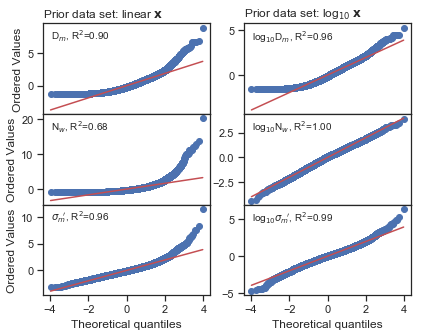

In [6]:
ncols = 2
fig, sps = plt.subplots(figsize=(6.6, 5), nrows=3, ncols=ncols, sharex=True)

sps = sps.reshape((3, ncols))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Smprime']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]
        data = (rainDat_training[x_var] - np.mean(
            rainDat_training[x_var])) / np.std(rainDat_training[x_var])
        (osm, osr), (slope, intercept, r) = stats.probplot(
            data, dist="norm", plot=sps[kk, ii], fit=True, rvalue=False)

        sps[kk, ii].set_title('')
        if kk == 0:
            sps[kk, ii].set_title(
                'Prior data set: %s $\mathbf{x}$' % (x_name),
                loc='left')

        sps[kk, ii].text(
            0.05,
            0.95,
            '%s, R$^2$=%.2f' % (
                supporting_routines.niceKeys[x_var], r**2
                #, x_mean, x_std
            ),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)

        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

fig.subplots_adjust(hspace=0)

The prior $\mathbf{x}_{a}$ and covariance **S**$_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

Dm                  1.461640
Nw               4054.575495
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Smprime_log10      -0.530466
dtype: float64


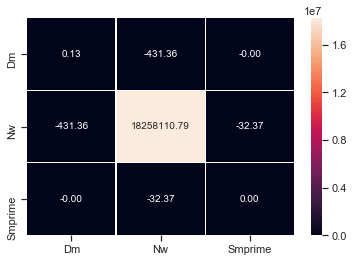

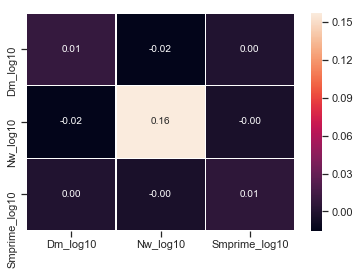

In [7]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm', 'Nw', 'Smprime']
    ].loc[
        ['Dm', 'Nw', 'Smprime']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

plt.figure()
sns.heatmap(
    S_a[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ].loc[
        ['Dm_log10', 'Nw_log10', 'Smprime_log10']
    ],
    annot=True,
    fmt='.2f',
    linewidths=.05)

When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. 

## Measurement space

The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 13.6 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  **S**$_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

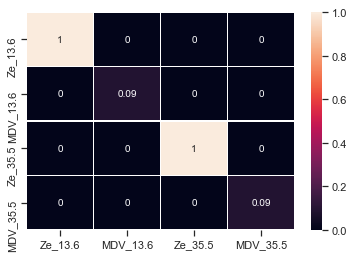

In [8]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
sns.heatmap(S_y, annot=True, fmt='g', linewidths=.05)

## Forward operator
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [9]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])


Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


The message about `relativePermittivityIce` can be ignored. After this, the forward operator can be run with `supporting_routines.forwardPamtra`.  In short, the forward operator accepts $\mathbf{x}$ as an input argument and returns $\mathbf{y}$. In addition, `pam2Prepared` (prepared above) and the list of $\mathbf{y}$ elements to be returned needs to be provided. See `libs/supporting_routines.py` for details.

# Example retrieval

First, we need names for the elements of $\mathbf{x}$  and $\mathbf{y}$ 

In [10]:
x_vars = ['Dm', 'Nw', 'Smprime']
y_vars = ["Ze_13.6", "MDV_13.6"]

Additional  variables required for the forward operator

In [11]:
forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

We use the 51st profile from the test data set as $\mathbf{x}_{truth}$

In [12]:
tt = 51
x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]

For simplicity, we use synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance by comparing $\mathbf{x}_{op}$ to $\mathbf{x}_{truth}$. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [13]:
y_obs = supporting_routines.forwardPamtra(
    x_truth,
    **forwardKwArgs,
)
y_obs

Ze_13.6     29.756770
MDV_13.6     6.194538
dtype: float64

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe` 

In [14]:
# create optimal estimation object
oe = pyOE.optimalEstimation(
    x_vars,  # state variable names
    x_ap[x_vars],  # a priori
    S_a[x_vars].loc[x_vars],  # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs,  # observations
    S_y[y_vars].loc[y_vars],  # observation uncertainty
    supporting_routines.forwardPamtra,  # forward Operator
    forwardKwArgs=forwardKwArgs,  # additonal function arguments
)

We store the true profile in the `oe` object. This is just for convenience, it is not
used by the retrieval.

In [15]:
oe.x_truth = x_truth

We run the retrieval with max. 10 iterations.

In [16]:
converged = oe.doRetrieval(maxIter=10)

0.43 s, iteration 1, degrees of freedom: 1.92 of 3. convergence criteria NOT fullfilled  1.375
0.58 s, iteration 2, degrees of freedom: 1.91 of 3. convergence criteria fullfilled  0.001
0.74 s, iteration 3, degrees of freedom: 1.91 of 3.  Done.  0.000


It converges after 2 iterations. 1.91 degrees of freedom for signal $d$ (the number of independent information pieces) are retrieved which is shows the good performance of the retrieval given that the maximum $d$ value is 2 because $\mathbf{y}$ consists of 2 measurements. 

After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with

In [17]:
print(oe.x_op)
print(oe.S_op)

Dm            1.444864
Nw         2102.003124
Smprime       0.306848
dtype: float64
                 Dm            Nw    Smprime
Dm         0.016757 -1.698757e+02  -0.004985
Nw      -169.875723  2.066878e+06  42.193265
Smprime   -0.004985  4.219327e+01   0.002522


pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are not mixed up.

For convenience, the 1 $\sigma$ uncertainties derived from **S**$_{op}$ are also available

In [18]:
print(oe.x_op_err)

Dm            0.129451
Nw         1437.664246
Smprime       0.050219
dtype: float64


$d$ is available as a total as well as per $\mathbf{x}$ variable

In [19]:
print('total', oe.dgf)
print(oe.dgf_x)

total 1.9093322923665519
Dm         0.904881
Nw         0.881159
Smprime    0.123292
dtype: float64


We recommend to apply various statistical tests to the result with the `chiSquareTest()` function. The tests include:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior **S**$_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior **S**$_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior **S**$_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 



In [20]:
print(oe.chiSquareTest()[0])

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


Finally, we test with `testLinearity()`  whether the forward operator is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`).

The first returned element is a boolean indicating whether the $\chi^2$ tests were successful: 

In [21]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe.linearityTest(
    significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  False


The fact that this test fails indicates already that the retrieval with linear $\mathbf{x}$ variables does not work properly (see below).

When running several retrievals, we recommend using the `oe.summarize` function which summarizes all retrieval results in an Xarray Dataset (which is structured similar to a netCDF file):

In [22]:
oe.summarize(returnXarray=True)

<xarray.Dataset>
Dimensions:                    (chi2test: 4, x_vars: 3, x_vars_T: 3, y_vars: 2, y_vars_T: 2)
Coordinates:
  * x_vars                     (x_vars) object 'Dm' 'Nw' 'Smprime'
  * x_vars_T                   (x_vars_T) object 'Dm' 'Nw' 'Smprime'
  * y_vars                     (y_vars) object 'Ze_13.6' 'MDV_13.6'
  * y_vars_T                   (y_vars_T) object 'Ze_13.6' 'MDV_13.6'
  * chi2test                   (chi2test) object 'Y_Optimal_vs_Observation' ... 'X_Optimal_vs_Prior'
Data variables:
    x_a                        (x_vars) float64 1.462 4.055e+03 0.2996
    x_a_err                    (x_vars) float64 0.3585 4.273e+03 0.05471
    S_a                        (x_vars, x_vars_T) float64 0.1285 ... 0.002993
    x_op                       (x_vars) float64 1.445 2.102e+03 0.3068
    x_op_err                   (x_vars) float64 0.1295 1.438e+03 0.05022
    S_op                       (x_vars, x_vars_T) float64 0.01676 ... 0.002522
    dgf_x                      (x_vars) f

# Run retrieval

After we presented the retrieval step-by-step, we integrate everything into a loop to apply the retrieval to all 100 profiles. 

The results are saved in dictionaries:

In [23]:
resultsOE = {}
failed = {}

To compare performance, we run the retrieval in two configurations:

1. linear state variables (see the step-by-step example above)
2. logarithmic state variables


In [24]:
#     name, [X_variables],
x_names = dict([
    ('Linear', ['Dm', 'Nw', 'Smprime']),
    ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
])

In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to experiment  with different configurations. 


In [25]:
#     name, [Y_variables],
y_names = dict([
    ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])

In [26]:
for x_name, y_name in (
    (
        'Linear',
        'ZW',
    ),
    ('log$_{10}$', 'ZW'),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s %s' % (x_name, y_name)] = []
    failed['%s %s' % (x_name, y_name)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name)
    print('#' * 80)

    #     for tt in [15, 20, 51]:
    for tt in range(rainDat_test[x_vars].time.shape[0]):

        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars],  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for convenience, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            print(oe.linearityTest())

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            if x_name.startswith('log'):
                # Show RMS normalized with prior
                print(
                    'RMS log',
                    np.sqrt(
                        np.mean(
                            ((10**oe.x_truth - 10**oe.x_op) / 10**oe.x_a)**2)))
                print('truth', 10**oe.x_truth)
                print('op', 10**unp.uarray(oe.x_op.values, oe.x_op_err.values))
            else:
                # Show RMS normalized with prior
                print('RMS',
                      np.sqrt(np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))
                print('truth', oe.x_truth)
                print('op', unp.uarray(oe.x_op.values, oe.x_op_err.values))

            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            summary['time'] = rainDat_test[x_vars].time[tt]

            resultsOE['%s %s' % (x_name, y_name)].append(summary)
        else:
            failed['%s %s' % (x_name, y_name)].append(tt)

    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s %s' % (x_name, y_name)] = xr.concat(
        resultsOE['%s %s' % (x_name, y_name)], dim='time')

################################################################################
Linear ZW
################################################################################
0.35 s, iteration 1, degrees of freedom: 1.77 of 3. convergence criteria fullfilled  0.017
0.50 s, iteration 2, degrees of freedom: 1.77 of 3.  Done.  0.000
([1.31664499661615, 0.00067507598515647, 0.0005244346764850746], array(0.06722079), 5.991464547107983)
Dm         0.967234
Nw         0.610596
Smprime    0.196107
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.170134
Y_Observation_vs_Prior      0.163760
Y_Optimal_vs_Prior          0.166656
X_Optimal_vs_Prior          0.161910
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observa

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.228994
Y_Observation_vs_Prior      0.159185
Y_Optimal_vs_Prior          0.156230
X_Optimal_vs_Prior          0.222604
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.03726930819105212
truth Dm            1.404538
Nw         2494.801381
Smprime       0.320172
Name: 2009-12-18 11:18:00, dtype: float64
op [1.427853800139899+/-0.1263980962460578
 2329.0098640633687+/-1556.0023772002799
 0.30599205657348+/-0.05001430846211044]
0.58 s, iteration 1, degrees of freedom: 1.94 of 3. convergence criteria NOT fullfilled  3.753
0.82 s, 

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.52 s, iteration 1, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  15.879
0.68 s, iteration 2, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  193.929
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.87 s, iteration 3, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfi

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.78 s, iteration 3, degrees of freedom: 0.88 of 3. convergence criteria NOT fullfilled  14.529
0.94 s, iteration 4, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  61.876
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 5
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 5
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 5
1.21 s, iteration 5, degrees of freedom: 0.88 of 3. convergence criteria NOT fullfil

0.37 s, iteration 1, degrees of freedom: 1.69 of 3. convergence criteria NOT fullfilled  21.275
0.56 s, iteration 2, degrees of freedom: 1.55 of 3. convergence criteria NOT fullfilled  0.403
0.74 s, iteration 3, degrees of freedom: 1.54 of 3. convergence criteria fullfilled  0.137
1.06 s, iteration 4, degrees of freedom: 1.55 of 3.  Done.  0.076
([4.465147361366826, 0.0026575111496453946, 0.0007264134977964424], array(164.90708527), 5.991464547107983)
Dm         0.628634
Nw         0.753585
Smprime    0.166226
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    17.500753
Y_Observation_vs_Prior      43.089511
Y_Optimal_vs_Prior          66.708841
X_Optimal_vs_Prior          16.938746
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_O

0.80 s, iteration 3, degrees of freedom: 1.91 of 3.  Done.  0.000
([5.776111889582011, 0.0010488243812035438, 0.0006057006920062899], array(0.24441801), 5.991464547107983)
Dm         0.940750
Nw         0.893072
Smprime    0.079610
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.283374
Y_Observation_vs_Prior      0.936047
Y_Optimal_vs_Prior          0.935063
X_Optimal_vs_Prior          1.189404
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.21741959955239828
truth Dm            1.079676
Nw         3174.033095
Smprime       0.366346
Name: 2010-10-21 02:50:

1.66 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  34.458
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 9
1.87 s, iteration 9, degrees of freedom: 0.95 of 3. convergence criteria NOT fullfilled  1.963
0.49 s, iteration 1, degrees of freedom: 1.59 of 3. convergence criteria NOT fullfilled  1.285
0.79 s, iteration 2, degrees of freedom: 1.59 of 3. convergence criteria fullfilled  0.001
1.00 s, iteration 3, degrees of freedom: 1.59 of 3.  Done.  0.000
([0.10326384960033312, 0.001976655417084655, 0.0006508268233795794], array(0.10490149), 5.991464547107983)
Dm         0.997677
Nw         0.379306
Smprime    0.211146
dtype: float64
Warning. Sing

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 1
0.34 s, iteration 1, degrees of freedom: 0.95 of 3. convergence criteria NOT fullfilled  4.006
0.55 s, iteration 2, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  53.591
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.76 s, iteration 3, degrees of freedom: 0.95 of 3. convergence criteria NOT fullfill

0.88 s, iteration 1, degrees of freedom: 1.71 of 3. convergence criteria fullfilled  0.139
1.40 s, iteration 2, degrees of freedom: 1.71 of 3.  Done.  0.000
([0.7845655632671938, 0.0007311549017471492, 0.00042775105539265106], array(0.00049912), 5.991464547107983)
Dm         0.982098
Nw         0.510025
Smprime    0.215189
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.524117
Y_Observation_vs_Prior      0.600364
Y_Optimal_vs_Prior          0.658275
X_Optimal_vs_Prior          0.504513
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.06306534661504129
truth

0.29 s, iteration 1, degrees of freedom: 1.92 of 3. convergence criteria NOT fullfilled  1.375
0.63 s, iteration 2, degrees of freedom: 1.91 of 3. convergence criteria fullfilled  0.001
1.07 s, iteration 3, degrees of freedom: 1.91 of 3.  Done.  0.000
([5.666036087335593, 0.001473405253310826, 0.00013354542546119814], array(10.52868809), 5.991464547107983)
Dm         0.904881
Nw         0.881159
Smprime    0.123292
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.274115
Y_Observation_vs_Prior      0.165154
Y_Optimal_vs_Prior          0.161365
X_Optimal_vs_Prior          0.257174
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

1.25 s, iteration 6, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  20.416
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 7
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 7
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 7
1.52 s, iteration 7, degrees of freedom: 0.91 of 3. convergence criteria NOT fullfilled  9.952
1.69 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  20.416
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Smprime from nan to 0.299574 in i

0.65 s, iteration 1, degrees of freedom: 1.68 of 3. convergence criteria NOT fullfilled  0.433
0.88 s, iteration 2, degrees of freedom: 1.69 of 3. convergence criteria fullfilled  0.001
1.05 s, iteration 3, degrees of freedom: 1.68 of 3.  Done.  0.000
([0.767337194190131, 0.0017933320323577735, 2.5244153769885907e-05], array(0.00585909), 5.991464547107983)
Dm         0.953453
Nw         0.450274
Smprime    0.280160
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.141261
Y_Observation_vs_Prior      1.409772
Y_Optimal_vs_Prior          1.455238
X_Optimal_vs_Prior          1.178347
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.99 s, iteration 3, degrees of freedom: 0.89 of 3. convergence criteria NOT fullfilled  17.940
1.16 s, iteration 4, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  32.750
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 5
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 5
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 5
1.58 s, iteration 5, degrees of freedom: 0.89 of 3. convergence criteria NOT fullfil

0.36 s, iteration 1, degrees of freedom: 1.64 of 3. convergence criteria NOT fullfilled  0.579
0.54 s, iteration 2, degrees of freedom: 1.64 of 3. convergence criteria fullfilled  0.000
0.86 s, iteration 3, degrees of freedom: 1.64 of 3.  Done.  0.000
([0.46736864903412595, 0.0008628125648783515, 0.000353769138700646], array(0.01264103), 5.991464547107983)
Dm         0.990767
Nw         0.418213
Smprime    0.232109
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.218548
Y_Observation_vs_Prior      1.692797
Y_Optimal_vs_Prior          2.009413
X_Optimal_vs_Prior          1.214828
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.186403
Y_Observation_vs_Prior      0.135379
Y_Optimal_vs_Prior          0.131865
X_Optimal_vs_Prior          0.182744
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.3322026765347867
truth Dm            1.340155
Nw         4382.929148
Smprime       0.388834
Name: 2011-03-28 06:18:00, dtype: float64
op [1.5005680811896613+/-0.1334787792781599
 2368.0952146344+/-1596.5280625187816
 0.3083978768931034+/-0.049701620271150625]
0.38 s, iteration 1, degrees of freedom: 1.95 of 3. convergence criteria NOT fullfilled  45.336
0.80 s, iteration 2, degrees of freedom: 1.94 of 3. convergence criteria NOT fullfilled  0.305
1.03 

0.65 s, iteration 1, degrees of freedom: 1.71 of 3. convergence criteria fullfilled  0.093
0.96 s, iteration 2, degrees of freedom: 1.71 of 3.  Done.  0.000
([0.7516097556567316, 0.0007845100727163287, 0.00046235156412115154], array(0.18368242), 5.991464547107983)
Dm         0.974914
Nw         0.495808
Smprime    0.242434
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.422544
Y_Observation_vs_Prior      0.535298
Y_Optimal_vs_Prior          0.583502
X_Optimal_vs_Prior          0.417409
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 0.4435291288698721
truth 

############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 3
0.98 s, iteration 3, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  25.315
1.16 s, iteration 4, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  268.041
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 5
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 5
############################################################
reset due to nan: Smprime from nan to 0.299574 in iteration 5
1.40 s, iteration 5, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfi

0.30 s, iteration 1, degrees of freedom: 1.90 of 3. convergence criteria NOT fullfilled  7.481
0.44 s, iteration 2, degrees of freedom: 1.87 of 3. convergence criteria fullfilled  0.004
0.59 s, iteration 3, degrees of freedom: 1.86 of 3.  Done.  0.000
([4.548479739974739, 0.0016856276241699756, 0.00020032028834938658], array(0.14414384), 5.991464547107983)
Dm         0.967188
Nw         0.819156
Smprime    0.076262
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.387116
Y_Observation_vs_Prior      1.740155
Y_Optimal_vs_Prior          1.746689
X_Optimal_vs_Prior          2.150164
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optima

([0.009638331371125582, 0.00046694807955424537, 0.0001599541930173339], array(0.00979066), 5.991464547107983)
Dm_log10         0.952942
Nw_log10         0.656480
Smprime_log10    0.167053
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.297346
Y_Observation_vs_Prior      0.302991
Y_Optimal_vs_Prior          0.304429
X_Optimal_vs_Prior          0.297225
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.14411243222545408
truth Dm_log10            1.412155
Nw_log10         3515.230287
Smprime_log10       0.245828
Name: 2011-09-05 09:19:00, dtype: float64
op 

0.24 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.000
0.35 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
([0.006610559939195116, 0.0009221541201199863, 8.381748432335708e-05], array(0.00729611), 5.991464547107983)
Dm_log10         0.948102
Nw_log10         0.639092
Smprime_log10    0.201922
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.265065
Y_Observation_vs_Prior      0.262845
Y_Optimal_vs_Prior          0.262188
X_Optimal_vs_Prior          0.264999
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.

0.46 s, iteration 1, degrees of freedom: 1.72 of 3. convergence criteria fullfilled  0.170
0.57 s, iteration 2, degrees of freedom: 1.72 of 3.  Done.  0.000
([0.0008226773941876517, 0.0003544563724658537, 0.0002106549398552722], array(6.24699744e-05), 5.991464547107983)
Dm_log10         0.934128
Nw_log10         0.548378
Smprime_log10    0.233865
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.917218
Y_Observation_vs_Prior      4.500565
Y_Optimal_vs_Prior          5.070748
X_Optimal_vs_Prior          3.032651
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.31 s, iteration 1, degrees of freedom: 1.74 of 3. convergence criteria fullfilled  0.074
0.51 s, iteration 2, degrees of freedom: 1.74 of 3.  Done.  0.000
([0.0021499769181902635, 0.0006458761953134784, 0.0001224697949272131], array(2.21760057e-05), 5.991464547107983)
Dm_log10         0.945069
Nw_log10         0.584165
Smprime_log10    0.210189
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.766630
Y_Observation_vs_Prior      1.830286
Y_Optimal_vs_Prior          1.853637
X_Optimal_vs_Prior          1.774026
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.26 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria fullfilled  0.076
0.38 s, iteration 2, degrees of freedom: 1.75 of 3.  Done.  0.000
([0.0017998277758851425, 0.0007983000594889824, 0.0001325216671519129], array(0.00661386), 5.991464547107983)
Dm_log10         0.940288
Nw_log10         0.576447
Smprime_log10    0.230700
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.516018
Y_Observation_vs_Prior      1.929097
Y_Optimal_vs_Prior          2.065840
X_Optimal_vs_Prior          1.511798
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.26 s, iteration 1, degrees of freedom: 1.72 of 3. convergence criteria NOT fullfilled  0.616
0.41 s, iteration 2, degrees of freedom: 1.71 of 3. convergence criteria fullfilled  0.000
0.57 s, iteration 3, degrees of freedom: 1.71 of 3.  Done.  0.000
([0.009505162146118677, 0.00011505056874172615, 6.83153827072542e-05], array(0.04849957), 5.991464547107983)
Dm_log10         0.951568
Nw_log10         0.651642
Smprime_log10    0.108664
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.153403
Y_Observation_vs_Prior      2.900848
Y_Optimal_vs_Prior          3.130513
X_Optimal_vs_Prior          2.152158
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior       

Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.463964
Y_Observation_vs_Prior      2.508868
Y_Optimal_vs_Prior          2.521428
X_Optimal_vs_Prior          2.466603
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.2640837696145363
truth Dm_log10            1.477213
Nw_log10         7507.013983
Smprime_log10       0.196511
Name: 2010-09-25 14:49:00, dtype: float64
op [1.4041505360437818+/-0.1033600737362322
 8572.250738239725+/-4425.887657951821
 0.26527740262427596+/-0.042768350335964544]
0.33 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfi

0.31 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.011
0.43 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.003648729487895056, 0.0012137088299633693, 4.4191037460997714e-05], array(5.90003947e-06), 5.991464547107983)
Dm_log10         0.944604
Nw_log10         0.612991
Smprime_log10    0.222423
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.611193
Y_Observation_vs_Prior      0.634532
Y_Optimal_vs_Prior          0.642700
X_Optimal_vs_Prior          0.603725
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.28 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria fullfilled  0.080
0.46 s, iteration 2, degrees of freedom: 1.75 of 3.  Done.  0.000
([0.0017555263788082485, 0.0008359392824359251, 0.00013303940283959902], array(2.39680905e-05), 5.991464547107983)
Dm_log10         0.939436
Nw_log10         0.575490
Smprime_log10    0.234560
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.723120
Y_Observation_vs_Prior      2.165906
Y_Optimal_vs_Prior          2.312030
X_Optimal_vs_Prior          1.708337
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS 

0.30 s, iteration 1, degrees of freedom: 1.76 of 3. convergence criteria fullfilled  0.028
0.48 s, iteration 2, degrees of freedom: 1.76 of 3.  Done.  0.000
([0.002995876929819662, 0.0008608538108733514, 7.65757343818209e-05], array(1.28338112e-05), 5.991464547107983)
Dm_log10         0.947518
Nw_log10         0.602885
Smprime_log10    0.206146
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.197643
Y_Observation_vs_Prior      1.151168
Y_Optimal_vs_Prior          1.143148
X_Optimal_vs_Prior          1.194886
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log

0.39 s, iteration 1, degrees of freedom: 1.73 of 3. convergence criteria NOT fullfilled  0.422
0.52 s, iteration 2, degrees of freedom: 1.72 of 3. convergence criteria fullfilled  0.000
0.73 s, iteration 3, degrees of freedom: 1.72 of 3.  Done.  0.000
([0.010435598692672667, 0.00012747001155423768, 9.027908947461735e-05], array(0.00374148), 5.991464547107983)
Dm_log10         0.952624
Nw_log10         0.656379
Smprime_log10    0.113322
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.925419
Y_Observation_vs_Prior      2.509715
Y_Optimal_vs_Prior          2.686080
X_Optimal_vs_Prior          1.924506
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior      

0.38 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.001
0.56 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.008870786739190626, 0.0006136943678384189, 0.00015276018961447773], array(1.82541655e-05), 5.991464547107983)
Dm_log10         0.949977
Nw_log10         0.649220
Smprime_log10    0.184613
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.241164
Y_Observation_vs_Prior      0.242009
Y_Optimal_vs_Prior          0.242004
X_Optimal_vs_Prior          0.240584
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS l

0.37 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.002
0.55 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.008953989619221335, 0.0005029223908532618, 0.00013541288079977338], array(0.00185328), 5.991464547107983)
Dm_log10         0.954032
Nw_log10         0.656699
Smprime_log10    0.165615
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.966812
Y_Observation_vs_Prior      0.976054
Y_Optimal_vs_Prior          0.978557
X_Optimal_vs_Prior          0.967760
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0

0.64 s, iteration 1, degrees of freedom: 1.78 of 3. convergence criteria fullfilled  0.001
0.85 s, iteration 2, degrees of freedom: 1.78 of 3.  Done.  0.000
([0.00520394560783546, 0.0009795983149899355, 4.317090672045684e-05], array(0.00137366), 5.991464547107983)
Dm_log10         0.949480
Nw_log10         0.632055
Smprime_log10    0.199015
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.195317
Y_Observation_vs_Prior      0.188971
Y_Optimal_vs_Prior          0.188246
X_Optimal_vs_Prior          0.195155
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
RMS log 0.2

0.29 s, iteration 1, degrees of freedom: 1.74 of 3. convergence criteria NOT fullfilled  0.230
0.44 s, iteration 2, degrees of freedom: 1.74 of 3. convergence criteria fullfilled  0.000
0.67 s, iteration 3, degrees of freedom: 1.74 of 3.  Done.  0.000
([0.011370752589642636, 0.00017232173170197423, 0.00012125800930925173], array(0.00049622), 5.991464547107983)
Dm_log10         0.951396
Nw_log10         0.653796
Smprime_log10    0.132044
dtype: float64
Warning. Singular Matrix with rank 2 instead of 3. (This is typically save to ignore)       
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.285209
Y_Observation_vs_Prior      1.503692
Y_Optimal_vs_Prior          1.538363
X_Optimal_vs_Prior          1.285235
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior     

# Analyze results


## Compare retrieval quality

Here we compare the retrieval quality by comparing the number of profiles that converged, passed the $\chi^2$-tests, and the linearity test:

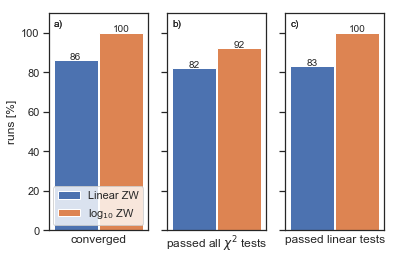

In [27]:
fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6, 4))

for kk, key in enumerate(resultsOE.keys()):

    converged = len(resultsOE[key].time)
    passedLinearity = (resultsOE[key].trueLinearityChi2 <
                       resultsOE[key].trueLinearityChi2Critical).sum().values
    passedChi2 = (resultsOE[key].chi2value <
                  resultsOE[key].chi2critical).all('chi2test').sum().values

    sps[0].bar(kk, converged, label=key, width=0.98)
    sps[1].bar(kk, passedChi2, label=key, width=0.98)
    sps[2].bar(kk, passedLinearity, label=key, width=0.98)

    sps[0].text(
        kk, converged + .25, str(converged), horizontalalignment='center')
    sps[1].text(
        kk, passedChi2 + .25, str(passedChi2), horizontalalignment='center')
    sps[2].text(
        kk,
        passedLinearity + .25,
        str(passedLinearity),
        horizontalalignment='center')

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear tests')
    sps[1].set_xlabel('passed all $\chi^2$ tests')

    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0, 110)
    sps[0].legend(loc='lower center')

    for ii in range(3):
        sps[ii].text(
            0.05,
            0.97,
            '%s)' % (abc[ii]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[ii].transAxes)

Independently how performance is measured, the version with the logarithmic $\mathbf{x}$ variables performs better. It should be noted that applying a $\chi^2$ test with 5% confidence interval to a larger number of retrievals means that 5% of the profiles do not pass the test even though they are fine.

## Compare retrieval error distributions

Similar to the prior, we also compare the distributions of relative retrieval errors defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathsf{S}_y)}}
   \end{equation}

In theory, the relative retrieval errors should follow a normal distribution with mean 0 and standard deviation 1. 

Linear ZW Dm 0.07109275362752564 0.7016137474506298
Linear ZW Nw -0.2303709216476416 0.6794944463667899
Linear ZW Smprime 0.013061075538017695 0.8475918056208038
log$_{10}$ ZW Dm_log10 0.05943233533481208 0.8885066185052868
log$_{10}$ ZW Nw_log10 -0.049210718868360225 0.8247281075181255
log$_{10}$ ZW Smprime_log10 0.06880373828374176 0.9946721558115889


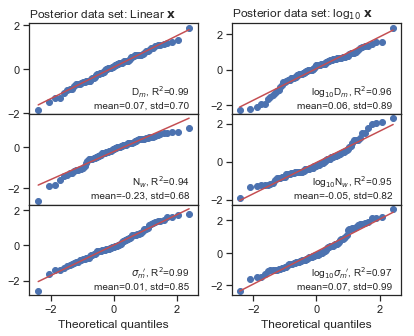

In [28]:
ncols = len(resultsOE.keys())
fig, sps = plt.subplots(
    figsize=(3.33 * ncols, 5), nrows=len(x_vars), ncols=ncols, sharex=True)

sps = sps.reshape((len(x_vars), ncols))

jj = 0

for yy, key in enumerate(resultsOE.keys()):

    for kk in range(3):

        x_var = resultsOE[key].x_vars.values[kk]
        thisOe = resultsOE[key].isel(x_vars=kk)
        passedChiTests = (thisOe.chi2value <=
                          thisOe.chi2critical).all('chi2test')
        thisOe = thisOe.where(passedChiTests).dropna('time')
        x_err = ((thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(key, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, yy], fit=True, rvalue=False)

        sps[kk, yy].set_title('')
        if kk == 0:
            sps[kk, yy].set_title(
                'Posterior data set: %s $\mathbf{x}$' %
                (key.split(' ')[0]),
                loc='left')

        sps[kk, yy].text(
            0.95,
            0.05,
            '%s, R$^2$=%.2f\nmean=%.2f, std=%.2f' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, yy].transAxes)

        if kk < 2:
            sps[kk, yy].set_xlabel("")
        sps[kk, yy].set_ylabel("")

        jj += 1

fig.subplots_adjust(hspace=0)

With one exception, mean and standard deviation are closer to 0 and 1, respectively, for the logarithmic retrieval. In other words, non-normally distributed state variables lead to non-normally distributed retrieval error distributions. In this case, the retrieval uncertainty is not correctly described with **S**$_{op}$. 

## Compare retrieval information content

Here, we compare the information content of the two retrieval versions. For this we use the ratio of relative uncertainty reduction with respect to the prior (defined as sqrt[diag(**S**$_{op}$)/diag(**S**$_a$)]) and the individual *d* for all profiles

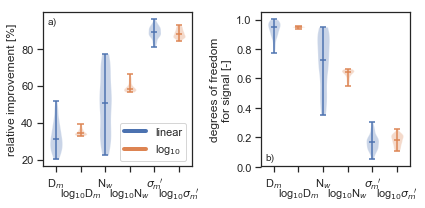

In [29]:

fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize=(6,3))
positions = np.array([0,2,4])
                     


for yy, key in enumerate(resultsOE.keys()):

    thisOE = resultsOE[key].where((resultsOE[key].chi2value < resultsOE[key].chi2critical).all('chi2test'))
    
    dat = (thisOE['x_op_err']/thisOE['x_a_err']).to_pandas().dropna() * 100
    ax1.violinplot(dat.T, positions = positions+yy, showmedians=True)


    dat = (thisOE['dgf_x']).to_pandas().dropna()
    ax2.violinplot(dat.T, positions = positions+yy, showmedians=True)
    
    
cols = ['Dm', 'Dm_log10', 'Nw', 'Nw_log10', 'Smprime', 'Smprime_log10']
labels = []
for tt in cols:
    labels.append(supporting_routines.niceKeys[tt].replace('log','\nlog'))
ax2.set_xticks(range(6)) 
ax2.set_xticklabels(labels) 
ax1.set_xticks(range(6)) 
ax1.set_xticklabels(labels) 

ax1.set_ylabel('relative improvement [%]')
ax2.set_ylabel('degrees of freedom\nfor signal [-]')

custom_lines = [matplotlib.lines.Line2D([0], [0], color='C0', lw=4),
                matplotlib.lines.Line2D([0], [0], color='C1', lw=4),
               ]

ax1.legend(custom_lines, ['linear', 'log$_{10}$'], loc='lower right')
ax1.text(0.03, 0.97, 'a)', horizontalalignment='left', verticalalignment='top', transform = ax1.transAxes)
ax2.text(0.03, 0.03, 'b)', horizontalalignment='left', verticalalignment='bottom', transform = ax2.transAxes)

plt.tight_layout()
plt.savefig('Figure4.png', dpi=200)
plt.savefig('Figure4.pdf')


The clear reduction in spread when using the logarithm of the state variables is obvious indicating that the retrieval produces more consistent results that do not depend as much on the individual profile. Interestingly, the median values are better for the linear state variables indicating that the linear retrieval version is underestimating retrieval uncertainties and overestimating *d*.

# References

Mech, M., M. Maahn, S. Kneifel, D. Ori, E. Orlandi, P. Kollias, V. Schemann, and S. Crewell, 2020: PAMTRA 1.0: A Passive and Active Microwave radiative TRAnsfer tool for simulating radiometer and radar measurements of the cloudy atmosphere. Geosci. Model Dev., submitted.

Testud, J., S. Oury, R. A. Black, P. Amayenc, and X. Dou, 2001: The concept of normalized distribution to describe raindrop spectra: A tool for cloud physics and cloud remote sensing. *J. Appl. Meteorol.*, 40, 1118–1140, [https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2](https://doi.org/10.1175/1520-0450(2001)040<1118:TCONDT>2.0.CO;2).

Williams, C. R., V. N. Bringi, L. D. Carey, V. Chandrasekar, P. N. Gatlin, Z. S. Haddad, R. Meneghini, S. Joseph Munchak, S. W. Nesbitt, W. A. Petersen, S. Tanelli, A. Tokay, A. Wilson, and D. B. Wolff, 2014: Describing the Shape of Raindrop Size Distributions Using Uncorrelated Raindrop Mass Spectrum Parameters. *J. Appl. Meteor. Climatol.*, 53, 1282–1296, https://doi.org/10.1175/JAMC-D-13-076.1.


